# Landsat Testing Dataset
## [Using Novelty Detection in Keras with Generative Adversarial Network]

This notebook is for test phase Novelty Detection. To Train the model, run this first.
```bash
python models.py
```

It is recommended to understand how the model works in general before continuing the implementation. 

→ [How to do Novelty Detection in Keras with Generative Adversarial Network (Part 1)](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/)


In [37]:
from utils import *
from kh_tools import *
import models
import imp
imp.reload(models)
from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
self =ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)


discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
d_h0_conv (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
d_h1_conv (Conv2D)           (None, 7, 7, 32)          12832     
_________________________________________________________________
batch_normalization_31 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 7, 7, 32)          0         
_________________________________________________________________
d_h2_conv (Conv2D)           (None, 4, 4, 64)          51264 

## Choose a stopping criterion
The training procedure is stopped when R successfully maps noisy images to clean images carrying the concept of the target class.  When R can reconstruct its input with minimum error. In the following case, we pick the epoch 3.

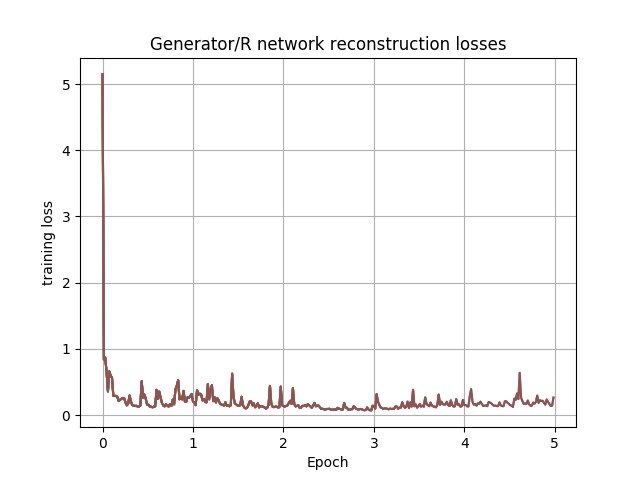

In [74]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image
Image(filename='plot_g_recon_losses.png') 


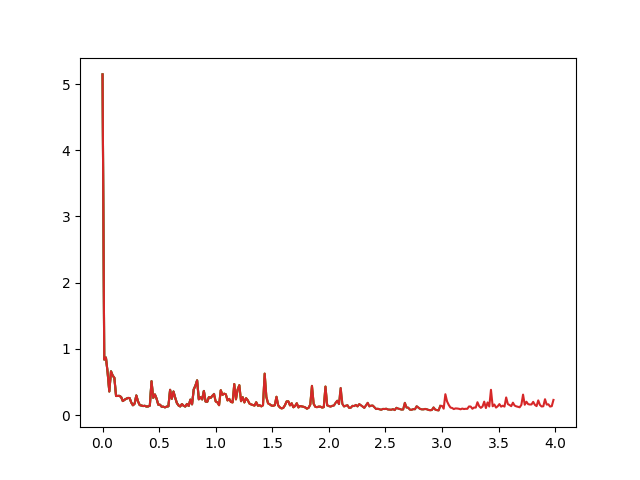

In [73]:
from IPython.display import Image
Image(filename='plot_g_recon_losses_3.png')

In [55]:
# Load the epoch #3 saved weights.
self.adversarial_model.load_weights('./checkpoint/ALOCC_Model_4.h5')

In [56]:

(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train / 255

## Test the reconstruction loss and Discriminator output
The `abnormal` image has a **`larger` reconstruction loss** and **`smaller` discriminator output value**.

In [57]:
def test_reconstruction(label, data_index = 11):
    specific_idx = np.where(y_train == label)[0]
    if data_index >= len(X_train):
        data_index = 0
    data = X_train[specific_idx].reshape(-1, 28, 28, 1)[data_index:data_index+1]
    model_predicts = self.adversarial_model.predict(data)
    
    fig= plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data.reshape((28, 28))
    reconstructed_image = model_predicts[0].reshape((28, 28))
    plt.title('Input')
    plt.imshow(input_image, label='Input')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
    # Compute the mean binary_crossentropy loss of reconstructed image.
    y_true = K.variable(reconstructed_image)
    y_pred = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print('Reconstruction loss:', error)
    print('Discriminator Output:', model_predicts[1][0][0])

### Normal case
The network was trained with label == 1.

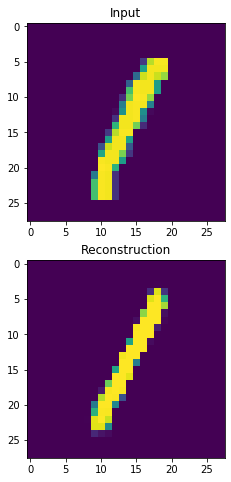

Reconstruction loss: 0.092682235
Discriminator Output: 0.36125582


In [58]:
test_reconstruction(1)

## Abnormal cases
The network was not trained on those labels, so the Generator/R network find it hard to reconstruct the input images reflected in higher reconstruction loss values.

Discriminator also outputs a lower value compared to normal ones.

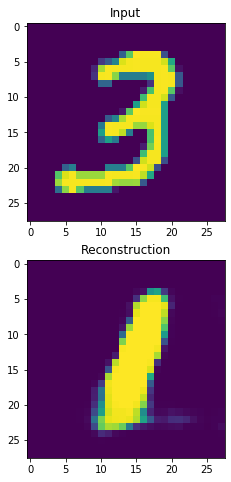

Reconstruction loss: 0.97681373
Discriminator Output: 0.37664634


In [59]:
test_reconstruction(3)

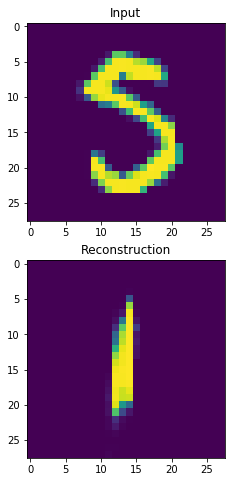

Reconstruction loss: 0.94355774
Discriminator Output: 0.4031163


In [49]:
test_reconstruction(5)

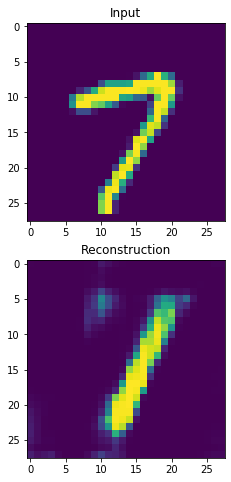

Reconstruction loss: 0.6265337
Discriminator Output: 0.3243893


In [17]:
test_reconstruction(7)